## ConvNets on MNIST Data

In this notebook we will perform classification analysis of MNIST digits
using multilayer CNN implemented using Keras. We will:

<ul>
<li>Implement load_mnist_digits() function to load MNIST digits dataset</li>
<li>Impplement flattent_and_normalize() function to preprocess images for classification</li>
<li>Train random forest model and apply it to test images</li>
<li>Implement F1 score to measure classification performance</li>
<li>Visualize importance of individual pixels for classification</li>
<li>Implement misclassified_digits() function to visualize misclassified examples by label</li>
<li>Report confusion matrix to evaluate most frequent error types</li>
</ul>

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import mnist
import keras
from keras.optimizers import Adam
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, BatchNormalization
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

%matplotlib inline
np.random.seed(1)

Load MNIST data.

In [2]:
# Load mnist digits

def load_mnist_digits():
    """
    Loads and returns MNIST digits dataset
    
    Returns:
    X_train -- training image examples, of shape (60000, 78, 78)
    Y_train -- training image labels, of shape (60000, )
    m_train -- number of training image examples, of type "integer"
    
    X_test -- test image examples, of shape (10000, 78, 78)
    Y_test -- test image labels, of shape (10000, )
    m_test -- number of test image examples, of type "integer"
    
    classes -- number of distinct classes (10)
    """
    
    X_train = mnist.train_images()
    Y_train = mnist.train_labels()
    
    X_test = mnist.test_images()
    Y_test = mnist.test_labels()

    m_train = X_train.shape[0]
    m_test = X_test.shape[0]
    
    classes = np.unique(Y_train)
    
    return X_train, Y_train, m_train, X_test, Y_test, m_test, classes

X_train_orig, Y_train_orig, m_train, X_test_orig, Y_test_orig, m_test, classes = load_mnist_digits()
n_y = len(classes)

In [3]:
def preprocess_data(X, Y):
    """
    Normalizes and prepares data for inputting into the model
    
    Arguments:
    X -- matrix of image examples, of shape (m, 28, 28), of type "float"
    Y -- matrix of image labels, of shape (m, ) and type "int"
    
    Returns:
    X -- a matrix of image examples, of shape (m, 28, 28, 1) and type "float"
    Y -- a one hot encodeing matrix of image labels, of shape (m, 10) and type "float"
    """
    
    X = X.astype('float32')
    X = X / 255.0
    
    X = np.reshape(X, (X.shape[0], 28, 28, 1))
    Y = to_categorical(Y)
    
    return X, Y
    
X_train, Y_train = preprocess_data(X_train_orig, Y_train_orig)
X_test, Y_test = preprocess_data(X_test_orig, Y_test_orig)

## Define convolutional model

Define a convolutional model to map pixel values of digits to digit labels. The model consists of the following steps:

Conv2D -> MaxPool -> Conv2D -> MaxPool -> Conv2D -> MaxPool -> Flatten -> Dense -> Dense

<ul>
<li>Conv2D with 32 filters, filter size (3, 3), padding 'same' and 'relu' activation</li>
<li>MaxPool with filter (2, 2) and 2 by 2 stride</li>
<li>Conv2D with 64 filters, filter size (3, 3), padding 'same' and 'relu' activation</li>
<li>MaxPool with filter (2, 2) and 2 by 2 stride</li>
<li>Conv2D with 128 filters, filter size (3, 3), padding 'same' and 'relu' activation</li>
<li>MaxPool with filter (2, 2) and 2 by 2 stride</li>
<li>Flatten the previous output</li>
<li>Dense layer 100 neurons and 'relu' activation</li>
<li>Dense layer 10 neurons and 'softmax' activation</li>
</ul>

In [4]:
def define_model():
    """
    Constructs multilayer convolutional model that maps pixel values to labels.

    Returns:
    
    model -- model to be trained
    """
    
    
    model = keras.Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", 
                     kernel_initializer='he_uniform', padding='same',
                     input_shape=(28, 28, 1)),)
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu",
                     kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu", 
                     kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    
    opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

Construct a model, print layer sizes and train model

In [6]:
model = define_model()

print("Layer shapes: ")
for layer in model.layers:
    print(layer.output_shape)
print("")

history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_test, Y_test))

Layer shapes: 
(None, 28, 28, 32)
(None, 14, 14, 32)
(None, 14, 14, 64)
(None, 7, 7, 64)
(None, 7, 7, 128)
(None, 3, 3, 128)
(None, 1152)
(None, 100)
(None, 10)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 64s 1ms/step - loss: 0.1221 - accuracy: 0.9631 - val_loss: 0.0354 - val_accuracy: 0.9877
Epoch 2/10
60000/60000 [==============================] - 65s 1ms/step - loss: 0.0404 - accuracy: 0.9870 - val_loss: 0.0342 - val_accuracy: 0.9885
Epoch 3/10
60000/60000 [==============================] - 65s 1ms/step - loss: 0.0311 - accuracy: 0.9903 - val_loss: 0.0336 - val_accuracy: 0.9891
Epoch 4/10
60000/60000 [==============================] - 65s 1ms/step - loss: 0.0217 - accuracy: 0.9932 - val_loss: 0.0322 - val_accuracy: 0.9901
Epoch 5/10
60000/60000 [==============================] - 65s 1ms/step - loss: 0.0175 - accuracy: 0.9943 - val_loss: 0.0288 - val_accuracy: 0.9915
Epoch 6/10
60000/60000 [=============================

Run test data through the model to predict class labels

In [7]:
Y_hat_test = model.predict_classes(X_test)

Plot misclassified examples

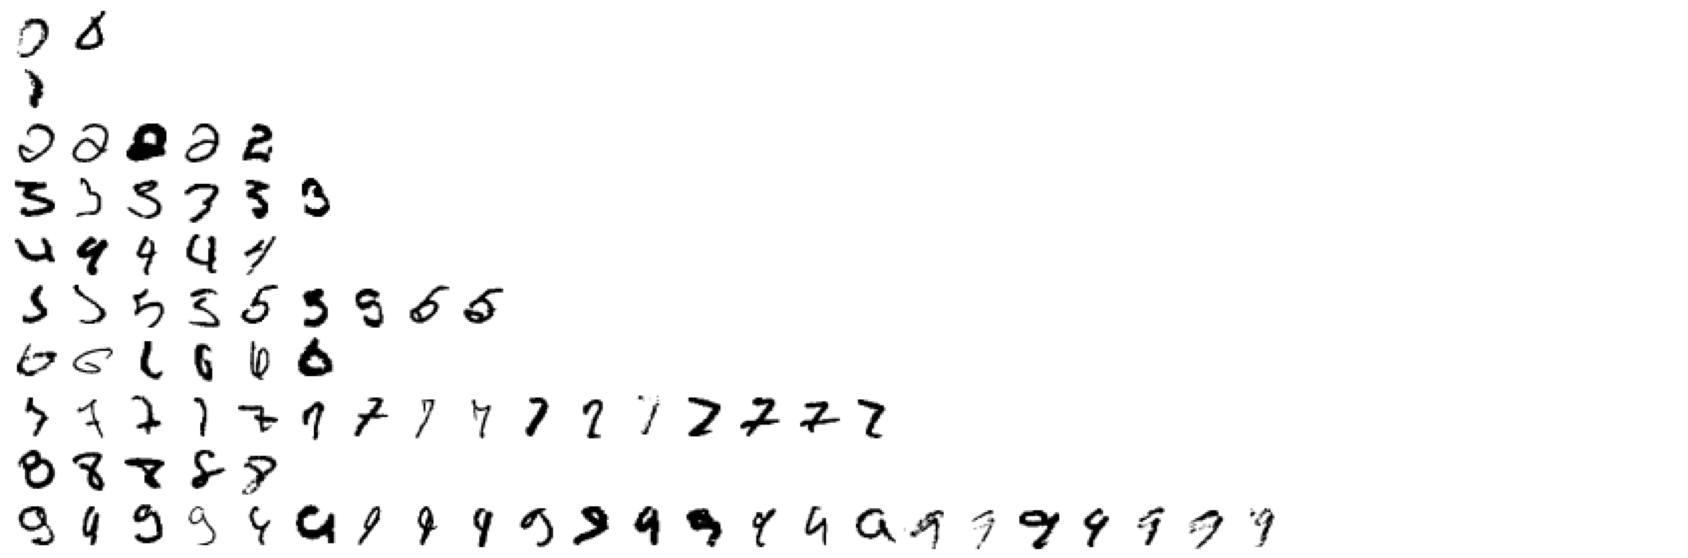

In [8]:
def plot_misclassified_digits(X, Y, Y_hat, max_examples=30):
    """
    Plots misclassified examples of digits
    
    Arguments:
    X -- matrix containing examples, of shape(m, 784)
    Y -- matrix of labels, of shape (m, )
    Y_hat -- matrix of predicted labels, of shape (m, )
    max_examples -- number of examples to show per label
    """
    
    misclassified = X[np.logical_not(np.equal(Y_hat, Y)), :]

    errors_by_label = np.zeros((10, max_examples, 28, 28))
    plot_examples = np.zeros((10*28, max_examples*28))
    for i in range(10):
        error_examples = X_test[np.multiply(Y == i, Y_hat != i), :]
        error_examples = np.reshape(error_examples, (error_examples.shape[0], 28, 28))

        for j in range(max_examples):
            if(j < error_examples.shape[0]):
                plot_examples[i*28:(i+1)*28, j*28:(j+1)*28] = error_examples[j, :, :]
            
    plot_examples = 1-plot_examples

    fig, ax = plt.subplots(figsize=(max_examples, 10))
    plt.imshow(plot_examples, cmap='gray', aspect='auto')
    plt.axis('off')
    plt.show()
    
    return
    
plot_misclassified_digits(X_test, Y_test_orig, Y_hat_test)

Print loss across epochs for train and validation data

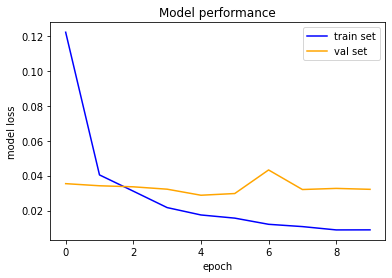

In [9]:
plt.plot(history.history['loss'], color='blue', label='train set')
plt.plot(history.history['val_loss'], color='orange', label='val set')
plt.title('Model performance')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("model loss")
plt.show()

Evaluate model's F1 score

In [12]:
def F1_score(Y_hat, Y):
    """
    Calculates average F1 score across classes
    
    Arguments:
    Y_hat -- vector of predicted labels, of shape (m, )
    Y  -- vector of true labels, of shape (m, )
    
    Returns:
    res -- real number, average F1 score
    """
    
    m = Y_hat.shape[0]
    
    ## Calculate per class accuracy
    scores = []
    unique_labels = np.unique(Y)
    for label in unique_labels:
        positives = np.sum(Y == label)
        true_positives = np.dot( (Y_hat == label).astype(int), (Y == label).astype(int))
        false_positives = np.dot( (Y_hat == label).astype(int), (Y != label).astype(int))
        
        negatives = np.sum(Y != label)
        true_negatives = np.dot( (Y_hat != label).astype(int), (Y != label).astype(int))
        false_negatives = np.dot( (Y_hat != label).astype(int), (Y == label).astype(int))

        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        F1_score = round(2 * precision * recall / (precision + recall), 5)
        
        scores.append(F1_score)
        
    res = round(np.mean(np.array(scores)), 2)
    return res
    
F1 = F1_score(Y_hat_test, Y_test_orig)
print("F1-score: " + str(F1))

F1-score: 0.99


Let's also evaluate confusion matrix of predictions.

In [15]:
confusion_matrix(Y_test_orig, Y_hat_test)

array([[ 978,    0,    0,    0,    0,    0,    1,    0,    0,    1],
       [   0, 1134,    0,    0,    0,    0,    0,    1,    0,    0],
       [   4,    0, 1027,    0,    0,    0,    0,    0,    1,    0],
       [   1,    0,    0, 1004,    0,    4,    0,    1,    0,    0],
       [   0,    0,    1,    0,  977,    0,    0,    1,    0,    3],
       [   0,    0,    0,    5,    0,  883,    3,    0,    0,    1],
       [   4,    1,    0,    0,    0,    0,  952,    0,    1,    0],
       [   0,    5,    7,    1,    2,    0,    0, 1012,    0,    1],
       [   1,    0,    1,    1,    0,    1,    0,    1,  969,    0],
       [   1,    1,    1,    2,    9,    4,    0,    4,    1,  986]])

As we can see, the majority of misclassified examples are as follows:
<ul>
<li>9 cases of 9 misclassified as 4</li>
<li>7 cases of 7 misclassified as 3</li>
<li>5 cases of 7 misclassified as 2</li>
<li>5 cases of 9 misclassified as 7</li>
<li>4 cases of 3 misclassified as 5</li>
</ul>
